<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## *Quantum_chemistry*



## Introduction


In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la


import sys
sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig
import math

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_circuit_ryrz,trial_circuit_ry, SPSA_optimization
from tools.optimizationtools import Energy_Estimate, Measure_pauli_z, Hamiltonian_from_file, make_Hamiltonian
from functools import partial



In [2]:
def eval_hamiltonian(n,m,file_name,device,shots,theta):


    file = open(file_name, 'r+')
    ham_array = file.readlines()
    ham_array = [x.strip() for x in ham_array]
    for i in range(len(ham_array)//2):
        string = ham_array[2*i]        
    
    avg_energy=0
    var_energy=0
    std_energy=0
    
    
    circuits=[]
    trial_circuit=[]
    
    Q_program = QuantumProgram()
    Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])
    
    
    # STACK QUANTUM CIRCUITS ASSOCIATED TO EACH PAULI TERM AND EXECUTE THEM 
    
    for i in range(len(ham_array)//2):     

        trial_circuit.append(trial_circuit_ryrz(n,m,theta,entangler_map,ham_array[i*2]))
        circuits.append("trial_circuit_label"+str(i))
        Q_program.add_circuit(circuits[i],trial_circuit[i])
        
        
    # EXECUTE THE CIRCUITS STACKED 
    Q_program.execute(circuits,device,shots)
    
    pauli_list=Hamiltonian_from_file(file_name)
    
    for i in range(len(ham_array)//2):#loop over Pauli terms
    
        pauli_avg=Energy_Estimate(Q_program.get_counts("trial_circuit_label"+str(i)),pauli_list[i])
        
        avg_energy+=pauli_avg
    
    
    
    
    return avg_energy,std_energy
                        

## Optimization of H2 at bond length

Energy at theta+ for step # 0
-0.9616971983565864
Energy at theta- for step # 0
-0.83754216238417
Energy at theta+ for step # 1
-1.4232447759015023
Energy at theta- for step # 1
-1.4201774870592982
Energy at theta+ for step # 2
-1.4010068569756544
Energy at theta- for step # 2
-1.4379528473910923
Energy at theta+ for step # 3
-1.4956121986532374
Energy at theta- for step # 3
-1.3803722083248626
Energy at theta+ for step # 4
-1.5702048591866966
Energy at theta- for step # 4
-1.5729095910978936
Energy at theta+ for step # 5
-1.5392262935160352
Energy at theta- for step # 5
-1.624805790903685
Energy at theta+ for step # 6
-1.6035415011964986
Energy at theta- for step # 6
-1.668293886513655
Energy at theta+ for step # 7
-1.6518165718040425
Energy at theta- for step # 7
-1.5640829663744185
Energy at theta+ for step # 8
-1.6777243851472157
Energy at theta- for step # 8
-1.6349848105562388
Energy at theta+ for step # 9
-1.6329599723356376
Energy at theta- for step # 9
-1.6713227431605688
Ener

/Users/amezzac/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


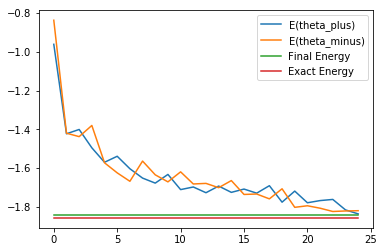

In [5]:
n=2
m=2
device='local_qasm_simulator'
SPSA_params=[1,.1,.602,.101,0]
theta=np.zeros(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1000
max_trials=25

#Exact Energy
pauli_list=Hamiltonian_from_file('H2/H2Equilibrium.txt')
eigen=la.eig(make_Hamiltonian(pauli_list))
exact=np.amin(eigen[0])
        
# Optimization
eval_hamiltonian_partial=partial(eval_hamiltonian,n,m,'H2/H2Equilibrium.txt',device,shots)
output=SPSA_optimization(eval_hamiltonian_partial,theta,SPSA_params,max_trials,1);
plt.plot(output[2],label='E(theta_plus)')
plt.plot(output[3],label='E(theta_minus)')
plt.plot(np.ones(max_trials)*output[0],label='Final Energy')
plt.plot(np.ones(max_trials)*exact,label='Exact Energy')
plt.legend()

## Optimizing the potential energy surface 

/Users/amezzac/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:55: ComplexWarning: Casting complex values to real discards the imaginary part



OPTIMIZING HAMILTONIAN # 0 AT INTERATOMIC DISTANCE 0.2 ANGSTROM

Energy at theta+ for step # 0
-0.6124904940292032
Energy at theta- for step # 0
-0.30933601415786394
Energy at theta+ for step # 1
-0.41194169771771605
Energy at theta- for step # 1
-0.3632622501943258
Energy at theta+ for step # 2
-0.23079187588449146
Energy at theta- for step # 2
-0.5733176214972563
Energy at theta+ for step # 3
-0.13298933222483406
Energy at theta- for step # 3
-0.34746148547636807
Energy at theta+ for step # 4
-0.7438709195547326
Energy at theta- for step # 4
-0.9107781449239992
Energy at theta+ for step # 5
-1.0469232202254053
Energy at theta- for step # 5
-0.8470822421487147
Energy at theta+ for step # 6
-1.1045839675923346
Energy at theta- for step # 6
-0.8100217590483354
Energy at theta+ for step # 7
-1.7435323696838783
Energy at theta- for step # 7
-1.7294039708982998
Energy at theta+ for step # 8
-1.7313720371700858
Energy at theta- for step # 8
-1.7460049108879974
Energy at theta+ for step # 9

Energy at theta+ for step # 19
-1.946516142679561
Energy at theta- for step # 19
-1.9314499278969457
Energy at theta+ for step # 20
-1.921427188256203
Energy at theta- for step # 20
-1.9585569527962015
Energy at theta+ for step # 21
-1.9202185229548776
Energy at theta- for step # 21
-1.979262340746022
Energy at theta+ for step # 22
-2.0212386447488058
Energy at theta- for step # 22
-1.922476646319962
Energy at theta+ for step # 23
-1.9982363064966555
Energy at theta- for step # 23
-2.0835507953327204
Energy at theta+ for step # 24
-2.062809787149266
Energy at theta- for step # 24
-2.0312005169116945
Energy at theta+ for step # 25
-2.0957253696629037
Energy at theta- for step # 25
-2.0525935900068633
Energy at theta+ for step # 26
-2.1214409758269204
Energy at theta- for step # 26
-2.06816526297138
Energy at theta+ for step # 27
-2.118640087537241
Energy at theta- for step # 27
-2.0861833831321337
Energy at theta+ for step # 28
-2.0642023047679015
Energy at theta- for step # 28
-2.09777

Energy at theta+ for step # 8
-1.301539399683101
Energy at theta- for step # 8
-1.163472059936693
Energy at theta+ for step # 9
-1.4156244250160106
Energy at theta- for step # 9
-1.3560168599994293
Energy at theta+ for step # 10
-1.4788747358047885
Energy at theta- for step # 10
-1.3069599560742173
Energy at theta+ for step # 11
-1.5394661419636624
Energy at theta- for step # 11
-1.527195943955213
Energy at theta+ for step # 12
-1.5633290104082598
Energy at theta- for step # 12
-1.5514369477854077
Energy at theta+ for step # 13
-1.5321053223597392
Energy at theta- for step # 13
-1.5562608126593869
Energy at theta+ for step # 14
-1.5386326969172726
Energy at theta- for step # 14
-1.5058172041731879
Energy at theta+ for step # 15
-1.4766492228151955
Energy at theta- for step # 15
-1.6136646772075018
Energy at theta+ for step # 16
-1.6987993031925332
Energy at theta- for step # 16
-1.6729289960374225
Energy at theta+ for step # 17
-1.623918249875115
Energy at theta- for step # 17
-1.73347

Energy at theta+ for step # 28
-1.5242424583715708
Energy at theta- for step # 28
-1.5890864834050575
Energy at theta+ for step # 29
-1.567316106780437
Energy at theta- for step # 29
-1.5757155109949825
Final Energy is: -1.573819526012393

OPTIMIZING HAMILTONIAN # 8 AT INTERATOMIC DISTANCE 1.0 ANGSTROM

Energy at theta+ for step # 0
-0.8797001194878347
Energy at theta- for step # 0
-0.888734669799724
Energy at theta+ for step # 1
-0.9138354325539306
Energy at theta- for step # 1
-0.8108941039216307
Energy at theta+ for step # 2
-0.9899107153510157
Energy at theta- for step # 2
-1.0986189694920248
Energy at theta+ for step # 3
-1.197471846586057
Energy at theta- for step # 3
-1.1904466406018535
Energy at theta+ for step # 4
-1.167662048442109
Energy at theta- for step # 4
-1.2438528926635457
Energy at theta+ for step # 5
-1.326735035073967
Energy at theta- for step # 5
-1.2550989829445183
Energy at theta+ for step # 6
-1.3415744787880426
Energy at theta- for step # 6
-1.35478314108583
E

Energy at theta+ for step # 17
-1.328818160730106
Energy at theta- for step # 17
-1.272845628251498
Energy at theta+ for step # 18
-1.3239482655560881
Energy at theta- for step # 18
-1.2896766660689416
Energy at theta+ for step # 19
-1.3121011317915368
Energy at theta- for step # 19
-1.318091228423474
Energy at theta+ for step # 20
-1.3256366109482627
Energy at theta- for step # 20
-1.3308284321961488
Energy at theta+ for step # 21
-1.2993897669590142
Energy at theta- for step # 21
-1.3189837006105136
Energy at theta+ for step # 22
-1.313634277570078
Energy at theta- for step # 22
-1.3036133447452989
Energy at theta+ for step # 23
-1.3264206132302443
Energy at theta- for step # 23
-1.3232117516682667
Energy at theta+ for step # 24
-1.3082561357404603
Energy at theta- for step # 24
-1.315595960649676
Energy at theta+ for step # 25
-1.2914861527362465
Energy at theta- for step # 25
-1.3232939467243927
Energy at theta+ for step # 26
-1.3224613115247805
Energy at theta- for step # 26
-1.32

Energy at theta+ for step # 6
-1.088311709313979
Energy at theta- for step # 6
-1.0783036705316331
Energy at theta+ for step # 7
-1.0590043837247813
Energy at theta- for step # 7
-1.1004563234784808
Energy at theta+ for step # 8
-1.1261853854647208
Energy at theta- for step # 8
-1.0474464813692361
Energy at theta+ for step # 9
-1.114039130464478
Energy at theta- for step # 9
-1.1200611441824897
Energy at theta+ for step # 10
-1.1280962980175429
Energy at theta- for step # 10
-1.095290562944848
Energy at theta+ for step # 11
-1.1388383921235012
Energy at theta- for step # 11
-1.1038479726438983
Energy at theta+ for step # 12
-1.1745713771861763
Energy at theta- for step # 12
-1.1033764903169192
Energy at theta+ for step # 13
-1.1703776103856842
Energy at theta- for step # 13
-1.1765062237401696
Energy at theta+ for step # 14
-1.1713749515498835
Energy at theta- for step # 14
-1.1842101765496962
Energy at theta+ for step # 15
-1.1696024247008594
Energy at theta- for step # 15
-1.17464691

Energy at theta+ for step # 26
-1.092318581285467
Energy at theta- for step # 26
-1.1747053792525821
Energy at theta+ for step # 27
-1.1963344680270287
Energy at theta- for step # 27
-1.171829267446313
Energy at theta+ for step # 28
-1.1965213185456098
Energy at theta- for step # 28
-1.159528237861867
Energy at theta+ for step # 29
-1.2064523777487965
Energy at theta- for step # 29
-1.1781874728933528
Final Energy is: -1.1928306822841135

OPTIMIZING HAMILTONIAN # 16 AT INTERATOMIC DISTANCE 1.8 ANGSTROM

Energy at theta+ for step # 0
-0.7180525658111863
Energy at theta- for step # 0
-0.7198731213088176
Energy at theta+ for step # 1
-0.6976720370130581
Energy at theta- for step # 1
-0.7335749882747261
Energy at theta+ for step # 2
-0.7572284823562785
Energy at theta- for step # 2
-0.715633661599103
Energy at theta+ for step # 3
-0.7483989334678292
Energy at theta- for step # 3
-0.7893383539493555
Energy at theta+ for step # 4
-0.7901837021021894
Energy at theta- for step # 4
-0.815073488

Energy at theta+ for step # 15
-1.0280193297653895
Energy at theta- for step # 15
-1.048757275954074
Energy at theta+ for step # 16
-1.0506948992952319
Energy at theta- for step # 16
-1.0360143961197676
Energy at theta+ for step # 17
-1.0409067948129396
Energy at theta- for step # 17
-1.0404641404439054
Energy at theta+ for step # 18
-1.0219815672194779
Energy at theta- for step # 18
-1.045421607432495
Energy at theta+ for step # 19
-1.048373597050773
Energy at theta- for step # 19
-1.0347288332015154
Energy at theta+ for step # 20
-1.0606870103470305
Energy at theta- for step # 20
-1.0189465942960099
Energy at theta+ for step # 21
-1.029348500640458
Energy at theta- for step # 21
-1.078994276345653
Energy at theta+ for step # 22
-1.0182134954827486
Energy at theta- for step # 22
-1.1186772345807228
Energy at theta+ for step # 23
-1.1563145830979378
Energy at theta- for step # 23
-1.1042942379932121
Energy at theta+ for step # 24
-1.156482541580902
Energy at theta- for step # 24
-1.130

Energy at theta+ for step # 4
-0.7248730726831571
Energy at theta- for step # 4
-0.6377228760518583
Energy at theta+ for step # 5
-0.8083753205238454
Energy at theta- for step # 5
-0.7991635553222447
Energy at theta+ for step # 6
-0.8242292970344047
Energy at theta- for step # 6
-0.7872430168872735
Energy at theta+ for step # 7
-0.7888176175822108
Energy at theta- for step # 7
-0.8134946067612455
Energy at theta+ for step # 8
-0.8115287118101574
Energy at theta- for step # 8
-0.8007009739583906
Energy at theta+ for step # 9
-0.8123794089680083
Energy at theta- for step # 9
-0.7930753820105076
Energy at theta+ for step # 10
-0.8058573299268827
Energy at theta- for step # 10
-0.8177600745086793
Energy at theta+ for step # 11
-0.835703165511894
Energy at theta- for step # 11
-0.8105477781793794
Energy at theta+ for step # 12
-0.8378621335689012
Energy at theta- for step # 12
-0.8106442629418796
Energy at theta+ for step # 13
-0.8654575861094005
Energy at theta- for step # 13
-0.7835709942

Energy at theta+ for step # 23
-0.7102238966661347
Energy at theta- for step # 23
-0.6563985358602276
Energy at theta+ for step # 24
-0.7171988400534675
Energy at theta- for step # 24
-0.6773168018044058
Energy at theta+ for step # 25
-0.714544763939819
Energy at theta- for step # 25
-0.7406929946354642
Energy at theta+ for step # 26
-0.7500986890355777
Energy at theta- for step # 26
-0.7278031977625915
Energy at theta+ for step # 27
-0.7152796594419865
Energy at theta- for step # 27
-0.7292066219541575
Energy at theta+ for step # 28
-0.7539057035581531
Energy at theta- for step # 28
-0.7099567149506203
Energy at theta+ for step # 29
-0.7158859112709476
Energy at theta- for step # 29
-0.7638672820113551
Final Energy is: -0.7561967451207081

OPTIMIZING HAMILTONIAN # 24 AT INTERATOMIC DISTANCE 2.6 ANGSTROM

Energy at theta+ for step # 0
-0.5746933226760127
Energy at theta- for step # 0
-0.5758128200765138
Energy at theta+ for step # 1
-0.5685221017154556
Energy at theta- for step # 1
-0.

Energy at theta+ for step # 11
-0.5393060225811026
Energy at theta- for step # 11
-0.5604264712276279
Energy at theta+ for step # 12
-0.5417460646492691
Energy at theta- for step # 12
-0.5697294767712221
Energy at theta+ for step # 13
-0.5550898005496336
Energy at theta- for step # 13
-0.5638450866987135
Energy at theta+ for step # 14
-0.567409528314909
Energy at theta- for step # 14
-0.5627105371581391
Energy at theta+ for step # 15
-0.5757363200950802
Energy at theta- for step # 15
-0.5437743679211505
Energy at theta+ for step # 16
-0.5712035810451225
Energy at theta- for step # 16
-0.5802559668557037
Energy at theta+ for step # 17
-0.5815329435639185
Energy at theta- for step # 17
-0.5749611806390682
Energy at theta+ for step # 18
-0.5895092738213736
Energy at theta- for step # 18
-0.5612670218026194
Energy at theta+ for step # 19
-0.5766663731987942
Energy at theta- for step # 19
-0.5995822681780366
Energy at theta+ for step # 20
-0.6031497978317866
Energy at theta- for step # 20
-

Final Energy is: -0.8651119437223813

OPTIMIZING HAMILTONIAN # 29 AT INTERATOMIC DISTANCE 3.1 ANGSTROM

Energy at theta+ for step # 0
-0.5007244657493752
Energy at theta- for step # 0
-0.5063990789042396
Energy at theta+ for step # 1
-0.5078329385626452
Energy at theta- for step # 1
-0.49872877383629294
Energy at theta+ for step # 2
-0.5049945503871134
Energy at theta- for step # 2
-0.511130681096299
Energy at theta+ for step # 3
-0.5076704487563177
Energy at theta- for step # 3
-0.5056803596101265
Energy at theta+ for step # 4
-0.5116186047746697
Energy at theta- for step # 4
-0.5147491266474392
Energy at theta+ for step # 5
-0.512272339424777
Energy at theta- for step # 5
-0.5098329409833913
Energy at theta+ for step # 6
-0.5041072371571087
Energy at theta- for step # 6
-0.5019567095909018
Energy at theta+ for step # 7
-0.5014961230354857
Energy at theta- for step # 7
-0.5105502306098727
Energy at theta+ for step # 8
-0.5072610583189541
Energy at theta- for step # 8
-0.51549565515935

Energy at theta+ for step # 18
-0.7916108026626347
Energy at theta- for step # 18
-0.7850882086714618
Energy at theta+ for step # 19
-0.7810488755738714
Energy at theta- for step # 19
-0.8104658142358168
Energy at theta+ for step # 20
-0.8312569559382077
Energy at theta- for step # 20
-0.7729295579524749
Energy at theta+ for step # 21
-0.8957374244007252
Energy at theta- for step # 21
-0.7943310602393031
Energy at theta+ for step # 22
-0.8840632534022523
Energy at theta- for step # 22
-0.8811812332909736
Energy at theta+ for step # 23
-0.8933011492066472
Energy at theta- for step # 23
-0.8496416541486611
Energy at theta+ for step # 24
-0.9464836274945407
Energy at theta- for step # 24
-0.8569452268078438
Energy at theta+ for step # 25
-0.9607757921028177
Energy at theta- for step # 25
-0.9378075302109764
Energy at theta+ for step # 26
-1.0088026886641737
Energy at theta- for step # 26
-0.9148300653702145
Energy at theta+ for step # 27
-1.0219109162577409
Energy at theta- for step # 27


Energy at theta+ for step # 6
-0.4620980126388409
Energy at theta- for step # 6
-0.47028657670617874
Energy at theta+ for step # 7
-0.4686888184340113
Energy at theta- for step # 7
-0.46104853468249396
Energy at theta+ for step # 8
-0.459397340955588
Energy at theta- for step # 8
-0.4596704047353131
Energy at theta+ for step # 9
-0.4617104925917642
Energy at theta- for step # 9
-0.4634276162234388
Energy at theta+ for step # 10
-0.4637358373761919
Energy at theta- for step # 10
-0.4544441273421225
Energy at theta+ for step # 11
-0.4702502717344978
Energy at theta- for step # 11
-0.4544109411385454
Energy at theta+ for step # 12
-0.457189007310955
Energy at theta- for step # 12
-0.46969000561933677
Energy at theta+ for step # 13
-0.4765625345731258
Energy at theta- for step # 13
-0.45586190521850745
Energy at theta+ for step # 14
-0.47035358366788177
Energy at theta- for step # 14
-0.46447913285504
Energy at theta+ for step # 15
-0.4702926573633931
Energy at theta- for step # 15
-0.4617

Energy at theta+ for step # 25
-0.5627502189515751
Energy at theta- for step # 25
-0.5174311608124811
Energy at theta+ for step # 26
-0.5684770656297186
Energy at theta- for step # 26
-0.5392534629951098
Energy at theta+ for step # 27
-0.5997297218806521
Energy at theta- for step # 27
-0.5258688387770489
Energy at theta+ for step # 28
-0.5703030247206924
Energy at theta- for step # 28
-0.642643536572057
Energy at theta+ for step # 29
-0.6292654781542499
Energy at theta- for step # 29
-0.6362032559120765
Final Energy is: -0.6258324717683224

OPTIMIZING HAMILTONIAN # 37 AT INTERATOMIC DISTANCE 3.9 ANGSTROM

Energy at theta+ for step # 0
-0.4328061531165372
Energy at theta- for step # 0
-0.4322135787114308
Energy at theta+ for step # 1
-0.43942876804208875
Energy at theta- for step # 1
-0.4388435484337305
Energy at theta+ for step # 2
-0.43468653418464703
Energy at theta- for step # 2
-0.4404806444243152
Energy at theta+ for step # 3
-0.4359904495284568
Energy at theta- for step # 3
-0.43

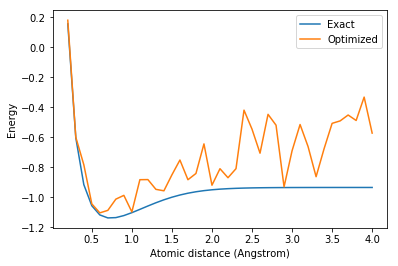

In [10]:
# MOLECULE PARAMETERS

molecule='H2' #name of the molecule: options are H2 or LiH

if molecule=='H2':
    n=2 # qubits
    Z1=1
    Z2=1
    min_distance=.2
    max_distance=4
    number_of_points=39
elif molecule=='LiH':
    n=4 # qubits
    Z1=1
    Z2=3
    min_distance=.5
    max_distance=5
    number_of_points=46
    
    
# OPTIMIZATION PARAMETERS 

run_optimization='Yes' # Choose 'Yes' or 'No'

m=2 # depth (number of layers of sq gates - # entanglers is this number -1)
device='local_qasm_simulator'
theta=np.zeros(2*n*m)  # initial angles 
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1000
max_trials=30
SPSA_params=[1,.1,.602,.101,0]



####################     COMPUTING FOR THE POTENTIAL ENERGY SURFACE      ###################

mol_distance=np.zeros(number_of_points)
coulomb_repulsion=np.zeros(number_of_points)
electr_energy=np.zeros(number_of_points)
electr_energy_optimized=np.zeros(number_of_points)

for i in range(number_of_points):

    
    # %%%%%%%%%%%%% Coulomb Repulsion For Diatomic molecules %%%%%%%%%%%%%%%%%%%%%%
        mol_distance[i]=np.around((min_distance+(max_distance-min_distance)*i/(number_of_points-1)),2)
        #print(mol_distance)
        distance=mol_distance[i]/0.529177
        coulomb_repulsion[i]=Z1*Z2/distance
        
    # exact diagonalization
        ham_text=molecule+'/PESMap'+str(i)+'atdistance'+str(mol_distance[i])+'.txt'
        pauli_list=Hamiltonian_from_file(ham_text)
        eigen=la.eig(make_Hamiltonian(pauli_list))
        electr_energy[i]=np.amin(eigen[0])
        
        
        
    # optimization
    
        if run_optimization=='Yes':
            print('\nOPTIMIZING HAMILTONIAN # '+str(i)+' AT INTERATOMIC DISTANCE '+str(mol_distance[i])+' ANGSTROM\n')
            eval_hamiltonian_partial=partial(eval_hamiltonian,n,m,ham_text,device,shots)
            electr_energy_optimized[i]=SPSA_optimization(eval_hamiltonian_partial,theta,SPSA_params,max_trials,1)[0]
            


plt.plot(mol_distance,electr_energy+coulomb_repulsion,label='Exact')
plt.plot(mol_distance,electr_energy_optimized+coulomb_repulsion,label='Optimized') 
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
        